# Indian Summers Time-Series Forecast

International news in recent years has reported on the record setting high temperatures in India during the summer, with such viral images of pedestrians whose melting shoes stick to the hot pavement. The objective of this analysis is to examine data from previous summers and attempt to predict max temperatures for future summers. 

## Preliminary

In [629]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import datetime as dt
import math
from PIL import Image
import warnings

Historic data is broken into two datasets. Need to check the columns are identical in both in order for us to combine the two datasets.

In [589]:
is1 = pd.read_csv('Indian Summers - Over the years-2007-11.csv')
print(is1.columns)

is2 = pd.read_csv('Indian Summers - Over the years.csv')
print(is2.columns)

Index(['City', 'Date', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description'],
      dtype='object')
Index(['City', 'Date', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description'],
      dtype='object')


In [627]:
print(is1['Date'])
print(is2['Date'])

0       2011-04-01
1       2011-04-02
2       2011-04-03
3       2011-04-04
4       2011-04-05
           ...    
6727    2007-06-26
6728    2007-06-27
6729    2007-06-28
6730    2007-06-29
6731    2007-06-30
Name: Date, Length: 6732, dtype: object
0        2021-04-01
1        2021-04-02
2        2021-04-03
3        2021-04-04
4        2021-04-05
            ...    
13645    2012-06-26
13646    2012-06-27
13647    2012-06-28
13648    2012-06-29
13649    2012-06-30
Name: Date, Length: 13650, dtype: object


Above results show we need to sort by date after data frames are concatenated.

The only variables necessary for the analysis are 'City,' 'Date,' and 'tempmax.' 

If we were looking to include exogenous variables in the analysis we could include 'moonphase.' In order to decide if we should include it, we should see if there is any correlation between the 'moonphase' and 'tempmax' variables for any of the cities.

In [591]:
is_raw = pd.concat([is1, is2], ignore_index=True)
data_a = is_raw[['City', 'Date', 'tempmax', 'moonphase']]

In [592]:
#Using a Spearman correlation coefficient to check if there are any linear or non-linear relationships

from scipy.stats import spearmanr

for i in data_a['City'].unique():
    data_c = data_a[data_a['City']==i]
    cc = spearmanr(a=data_c['moonphase'], b=data_c['tempmax'])
    print(f'{i}: {cc}')

Surat: SpearmanrResult(correlation=0.026947805210164946, pvalue=0.3197948068895695)
Jaipur: SpearmanrResult(correlation=nan, pvalue=nan)
Bhopal: SpearmanrResult(correlation=-0.006719592388887723, pvalue=0.8106321445002758)
Lucknow: SpearmanrResult(correlation=-0.048871161225655706, pvalue=0.07107252752372499)
Patna: SpearmanrResult(correlation=nan, pvalue=nan)
Indore: SpearmanrResult(correlation=0.004699264334420078, pvalue=0.8622894896807471)
Ahmedabad: SpearmanrResult(correlation=-0.014790405114018254, pvalue=0.5978973801871241)
Kanpur: SpearmanrResult(correlation=-0.04637238251452036, pvalue=0.08678220388937023)
Chennai: SpearmanrResult(correlation=0.015257730739049362, pvalue=0.5732802927841388)
Bengaluru: SpearmanrResult(correlation=0.010560304740710494, pvalue=0.696674490288403)
New Delhi: SpearmanrResult(correlation=-0.008852613177918267, pvalue=0.7439291098647465)
Mumbai: SpearmanrResult(correlation=0.031251230171697, pvalue=0.24857025566415888)
Hyderabad: SpearmanrResult(corre

None of the cities have a show a strong correlation between 'moonphase' and 'tempmax', therefore we will opt not to include 'moonphase' as an exogenous variable.

In [593]:
data_a = data_a[['City', 'Date', 'tempmax']]

In [594]:
data_a = data_a.sort_values(by=['City','Date'])
data_a

,City,Date,tempmax
6004,Ahmedabad,2007-04-01,39.1
6005,Ahmedabad,2007-04-02,40.1
6006,Ahmedabad,2007-04-03,40.1
6007,Ahmedabad,2007-04-04,41.1
6008,Ahmedabad,2007-04-05,43.1
...,...,...,...
7546,Surat,2021-06-26,32.9
7547,Surat,2021-06-27,32.9
7548,Surat,2021-06-28,31.1
7549,Surat,2021-06-29,33.2


Data is now sorted in alphabetical order by city and ascending chronological order by date. 

## EDA & Data Transformation

In order to simplify this time-series analysis, we will choose four cities out of the fifteen included in the data. The cities chosen are Bengaluru, Kolkata, Mumbai and New Delhi because they are amongst the cities with the highest population in India and also represent different geographical regions of the country.

In [595]:
data_a['City'].unique()

array(['Ahmedabad', 'Bengaluru', 'Bhopal', 'Chennai', 'Hyderabad',
       'Indore', 'Jaipur', 'Kanpur', 'Kolkata', 'Lucknow', 'Mumbai',
       'New Delhi', 'Patna', 'Pune', 'Surat'], dtype=object)

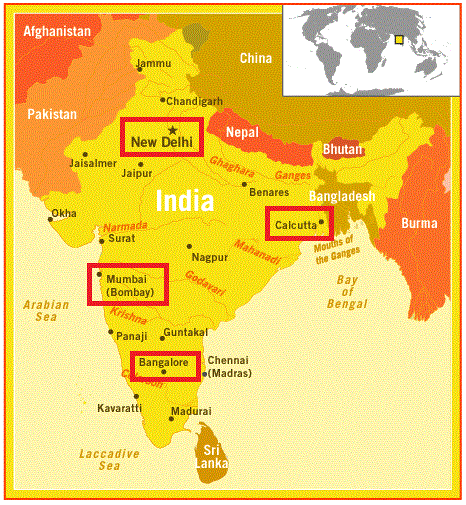

In [639]:
Image.open("map.gif")

In [596]:
data = pd.DataFrame(columns=data_a.columns)

for i in ['Bengaluru', 'Kolkata', 'Mumbai', 'New Delhi']:
    data = pd.concat([data, data_a[data_a['City']==i]], axis=0)

data

,City,Date,tempmax
6095,Bengaluru,2007-04-01,35.1
6096,Bengaluru,2007-04-02,36.1
6097,Bengaluru,2007-04-03,35.1
6098,Bengaluru,2007-04-04,36.1
6099,Bengaluru,2007-04-05,35.1
...,...,...,...
6818,New Delhi,2021-06-26,38.0
6819,New Delhi,2021-06-27,39.0
6820,New Delhi,2021-06-28,39.3
6821,New Delhi,2021-06-29,42.0


The data types shown below indicate that 'Date' will need to be changed to a DateTime format and 'tempmax' will need to be changed to a float format.

In [597]:
data.dtypes

City       object
Date       object
tempmax    object
dtype: object

In [598]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True, errors='ignore')
data['tempmax'] = data['tempmax'].astype(float)

We see below all variables are in the proper format and there are no null values.

In [599]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 6095 to 6822
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   City     5459 non-null   object        
 1   Date     5459 non-null   datetime64[ns]
 2   tempmax  5459 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 170.6+ KB


Below we will determine if the outlier datapoints are extreme values or whether they indicate erroneous or corrupt data. 

In [600]:
data.describe()

,tempmax
count,5459.000000
mean,34.709196
std,3.796343
min,23.100000
25%,32.100000
50%,34.100000
75%,37.000000
max,49.100000


The boxplot indicates the outlier datapoints are extreme values and not erroneous data that would need to be corrected.

<AxesSubplot:xlabel='City', ylabel='tempmax'>

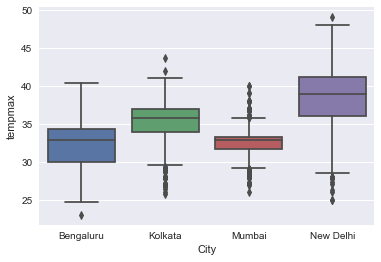

In [601]:
sns.boxplot(data=data, y='tempmax', x='City')

As an alternative to the 'Date' field we will create an integer field with values between 1 and 91, indicating the day within the overall summer period between 4/1 and 6/30.

In [602]:
data['day_of_summer'] = [(i - dt.datetime(i.year, 4, 1)).days + 1 for i in data['Date']]

The variability seen in the box plot can be viewed in more detail by using a line plot that aggregates the data for each ‘day_of_summer’ and shows the confidence intervals. 

We see that at one extreme, Mumbai–in comparison to the other cities–has a relatively smooth plot with few extreme jumps from day to day and the confidence intervals are relatively narrow. This indicates the max temperatures are relatively consistent from day to day and year to year. New Delhi represents the opposite extreme where the graph is relatively jagged with large jumps day to day and wide confidence intervals indicating inconsistency from year to year.

<AxesSubplot:xlabel='day_of_summer', ylabel='tempmax'>

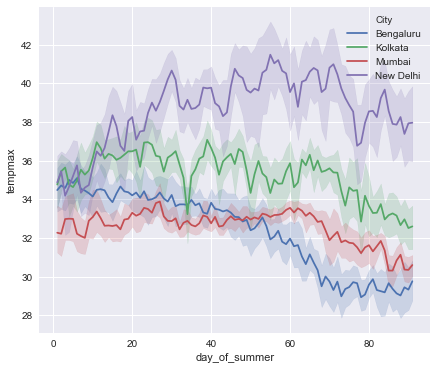

In [603]:
fig = plt.figure(figsize=(7,6))
sns.lineplot(data=data, x='day_of_summer', y='tempmax', hue='City')

It is impractical to work with daily data for purposes of decomposing the data into trend, seasonality and residuals, and ultimately making predictions. Even in the best case scenarios daily data is too noisy to accurately make predictions. It would be better to reduce the resolution to weekly data.

Below we create a field for 'week_of_summer' between 1 and 13, and also a field for 'year.' The 'tempmax' field is then aggregated using the mean of the seven constituent dates for each week.

In [604]:
data['week_of_summer'] = [math.ceil(i/7) for i in data['day_of_summer']]
data['year'] = [int(i.strftime("%Y")) for i in data['Date']]
data

,City,Date,tempmax,day_of_summer,week_of_summer,year
6095,Bengaluru,2007-04-01,35.1,1,1,2007
6096,Bengaluru,2007-04-02,36.1,2,1,2007
6097,Bengaluru,2007-04-03,35.1,3,1,2007
6098,Bengaluru,2007-04-04,36.1,4,1,2007
6099,Bengaluru,2007-04-05,35.1,5,1,2007
...,...,...,...,...,...,...
6818,New Delhi,2021-06-26,38.0,87,13,2021
6819,New Delhi,2021-06-27,39.0,88,13,2021
6820,New Delhi,2021-06-28,39.3,89,13,2021
6821,New Delhi,2021-06-29,42.0,90,13,2021


In [605]:
data_agg = data[['City', 'year', 'week_of_summer', 'tempmax']]
data_agg = data_agg.groupby(by=['City', 'year', 'week_of_summer']).mean()
data_agg = data_agg.reset_index()
data_agg

,City,year,week_of_summer,tempmax
0,Bengaluru,2007,1,35.785714
1,Bengaluru,2007,2,33.957143
2,Bengaluru,2007,3,32.200000
3,Bengaluru,2007,4,33.671429
4,Bengaluru,2007,5,32.585714
...,...,...,...,...
775,New Delhi,2021,9,37.100000
776,New Delhi,2021,10,39.000000
777,New Delhi,2021,11,36.428571
778,New Delhi,2021,12,36.728571


When plotting the line graph again using weeks instead of days we can get a sense of which cities may be easier to predict than others. Bengaluru has a smooth curve with narrow confidence intervals, indicating that its pattern of max temperatures is relatively consistent and, therefore, easier to predict. Kolkata, on the other hand, shows a more jagged plot, with multiple peaks and valleys which may indicate a lack of consistency that could make predictions more difficult. New Delhi, whose plot is relatively smooth, nevertheless shows wide confidence intervals which could also make it difficult to predict.

<AxesSubplot:xlabel='week_of_summer', ylabel='tempmax'>

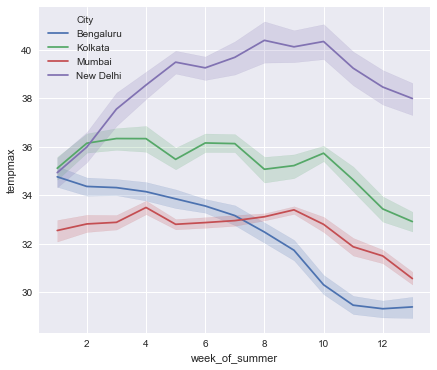

In [606]:
fig = plt.figure(figsize=(7,6))
sns.lineplot(data=data, x='week_of_summer', y='tempmax', hue='City')

## Modeling and Forecasts

For the purposes of forecasting, we will split the data into training and test sets by spllitting the last two years (2020, 2021) from the rest of the data. 

In [607]:
data_train = data_agg[data_agg['year'] < 2020]
data_test = data_agg[data_agg['year'] >= 2020]

Forecasts will be scored using the Mean Absolute Percent Error (MAPE)

In [608]:
def mape(actual, fcst):
    return abs(actual - fcst).sum() / actual.sum()

### Model #1: LOESS + ARMA

For the first model we will decompose the time-series data of max temperature into its trend, seasonal and residual components using LOESS. We will then subtract the seasonal component from the original data in order to make the data stationary so we can then determine the ideal ARMA order for the data. 

In [609]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

In [610]:
def LOESS_decomp(city, seasonal=21):

    #Decompose using LOESS
    data_c_train = data_train[data_train['City']==city].reset_index()
    stl = STL(data_c_train['tempmax'], period=13, seasonal=seasonal).fit()

    #Plot Decomposition
    fig, axList = plt.subplots(nrows=4, sharex=True)
    fig.set_size_inches(7,5)
    fig.suptitle(f'LOESS Decomposition ({city})')
    axis = np.arange(0,4,1)
    components = [stl.observed, stl.trend, stl.seasonal, stl.resid]
    titles = ['Observed','Trend','Seasonal', 'Residual']  
    for ax, comp, title in zip(axis, components, titles):
        axList[ax].plot(comp)
        axList[ax].set_ylabel(title)
        axList[ax].set_xticks(np.arange(0, 169, 13), labels=np.arange(2007, 2020, 1))
        axList[ax].grid(visible=True, axis='x')
    axList[3].fill_between(x=np.arange(0, 169, 1), y1=comp)
    plt.tight_layout()
    

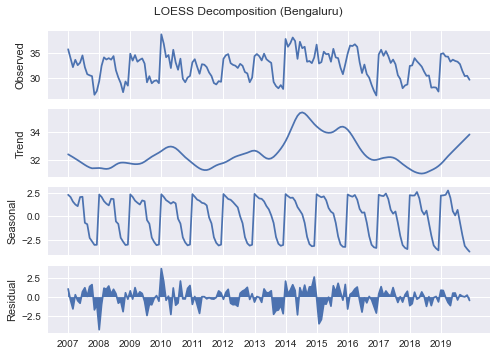

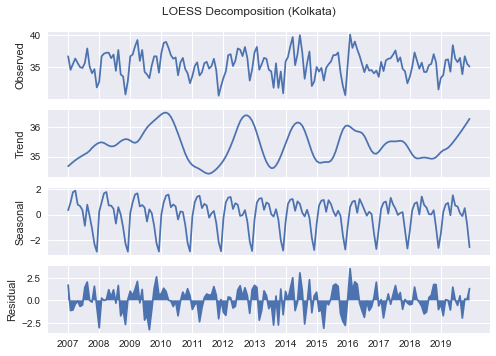

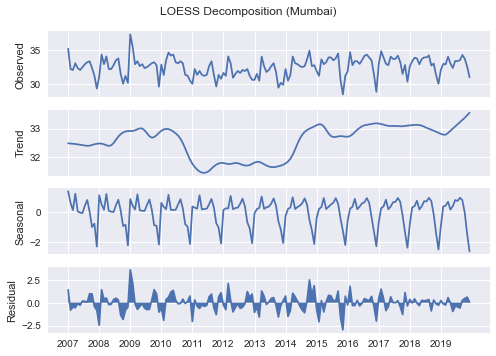

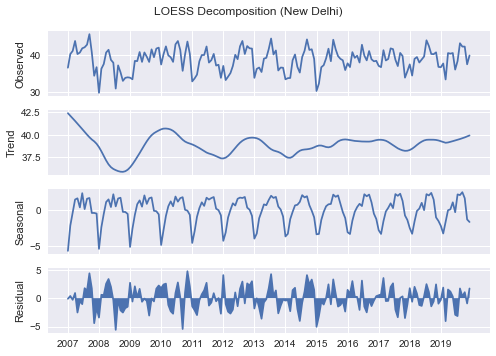

In [611]:
city_list = data['City'].unique()

for cities in city_list:
    LOESS_decomp(city=cities)

The decomposition of BENGALURU shows a relatively consistent seasonal component. The trend is also relatively flat, with the exception of the section covering years 2014 and 2015 where the trend is elevated by one to two degrees. 

The decomposition of KOLKATA shows the seasonal component for the last three years differs from those preceding it in that the lower temperatures at the end of the season do not dip as low as they did in the preceding years. The trend component fluctuates often between 35 and 36 degrees.

The decomposition of MUMBAI shows the seasonal component for years 2010-2015 differs from the other periods in that the lower temperatures at the end of the season do not dip as low as they did in the years surrounding this period. The trend also dips by roughly one degree during the same time period.

The decomposition of NEW DELHI shows the seasonal component maintaining the same periods of higher temperatures, however the periods of lower temperature at the beginning and end of the season become progressively higher. The trend component is more volatile during the first seven years then flattens out around 38-39 degrees in subsequent years.

In order to now fit the ARMA model, we'll need to create seasonally adjusted data by subtracting the seasonal component from the observed data.
At that point we can use a function to determine the best ARMA (p,q) order to use for each city's seasonally adjusted data. We can then forecast, score and plot the ARMA model for each city.

In [620]:
def ARMA_forecast(city, period=13, seasonal=21, max_ar=4, max_ma=5, ic=['aic']):
    
    #Decompose using LOESS
    data_c_train = data_train[data_train['City']==city].reset_index()
    data_c_test = data_test[data_test['City']==city].reset_index()
    stl = STL(data_c_train['tempmax'], period=period, seasonal=21).fit()
    data_c_train['tempmax_seas_adj'] = stl.observed - stl.seasonal

    #Determine ARMA order
    order = arma_order_select_ic(data_c_train['tempmax_seas_adj'], max_ar=max_ar, max_ma=max_ma, ic=ic)
    p, q = order.aic_min_order
    min_order = (p, 0, q)

    #Forecast
    stl_f = STLForecast(
        data_c_train['tempmax'], 
        period=period, 
        seasonal=seasonal, 
        model=ARIMA, 
        model_kwargs={"order": min_order}).fit()
    fcst = stl_f.forecast(26)
    data_c_test['forecast'] = np.array(fcst)

    #Score Model
    mape_score = mape(actual=data_c_test['tempmax'], fcst=data_c_test['forecast'])
    print(f'{city}: ARMA Order={res_arma.aic_min_order};  MAPE={mape_score}')
    
    #Plot Forecast
    fig = plt.figure(figsize=(6,4))
    tempmax_plt, = plt.plot(data_c_test['tempmax'])
    fcst_plt, = plt.plot(data_c_test['forecast'])
    plt.title(f'ARMA Forecast ({city})')
    plt.xlabel('Year')
    plt.ylabel('Avg. Max Weekly Temperature')
    plt.xticks(np.arange(0,26,13), labels=['2020','2021'])
    plt.ylim((ymin, ymax))
    plt.grid(visible=True, axis='x')
    plt.legend([tempmax_plt, fcst_plt], ['Actual','Forecast'])
    data_c_test['yr_wk'] = data_c_test['year'].astype(str) +"-"+ data_c_test['week_of_summer'].astype(str)
    return data_c_test

Bengaluru: ARMA Order=(2, 1);  MAPE=0.03093981621828587
Kolkata: ARMA Order=(2, 1);  MAPE=0.05462311474560982
Mumbai: ARMA Order=(2, 1);  MAPE=0.0206340344440505
New Delhi: ARMA Order=(2, 1);  MAPE=0.06682889510683905


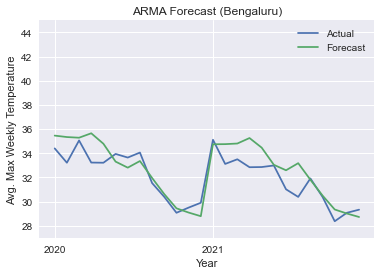

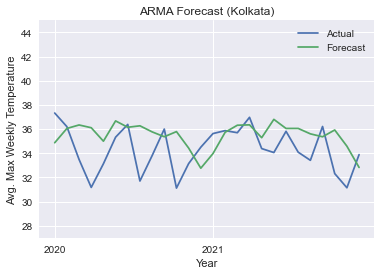

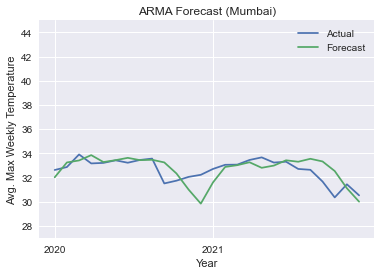

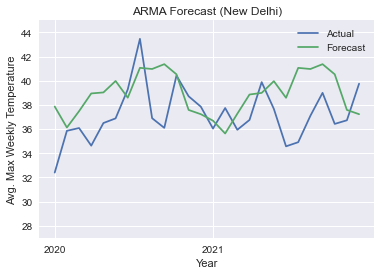

In [621]:
warnings.simplefilter(action='ignore', category='ConvergenceWarning')

for city, city_n in zip(city_list, city_list_n):
    exec(f"data_{city_n}_test = ARMA_forecast(city='{city}')")

warnings.resetwarnings()

As expected Bengaluru and Mumbai had more accurate forecasts while Kolkata and New Delhi had less accurate predictions. As previously discussed, Kolkata and New Delhi have inconsistant seasonal patterns with high variance making this model more prone to overfitting for those cities.

### Model #2: SARIMA

In [622]:
from pmdarima import auto_arima

For the SARIMA model, we will allow a function to determine the best SARIMA (p,d,q)(P,D,Q) order for each city. 

In [623]:
def SARIMA_forecast(city, start_p=0, start_q=0, max_p=6, max_q=6, max_P=6, max_Q=6):
    
    #Determine SARIMA order
    data_c_train = data_train[data_train['City']==city].reset_index()
    data_c_test = data_test[data_test['City']==city].reset_index()
    AA_model = auto_arima(
        y=data_c_train['tempmax'], 
        start_p=start_p, 
        start_q=start_q, 
        max_p=max_p, 
        max_q=max_q, 
        max_P=max_P, 
        max_Q=max_Q, 
        m=13,
        error_action='ignore')
    AA_model.fit(y=data_c_train['tempmax'])
    
    #Forecast
    AA_fcst = AA_model.predict(y=data_c_train['tempmax'], n_periods=26)
    data_c_test['forecast'] = np.array(AA_fcst)
    
    #Score Model
    mape_score = mape(actual=data_c_test['tempmax'], fcst=AA_fcst)
    print(f'{city}: SARIMA Order={AA_model.order}, {AA_model.seasonal_order};  MAPE={mape_score}')
    
    #Plot Forecast
    data_c_test['yr_wk'] = data_c_test['year'].astype(str) +"-"+ data_c_test['week_of_summer'].astype(str)
    data_c_test.plot(
        title=(f'SARIMA Forecast ({city})'),
        y=['tempmax','forecast'],
        ylabel='Avg. Max Weekly Temperature', 
        ylim=(ymin,ymax),
        x ='yr_wk',
        xlabel = 'Year')
    plt.legend(['Actual','Forecast'])
    plt.xticks(np.arange(0,26,13), labels=['2020','2021'])
    plt.grid(visible=True, axis='x')

Bengaluru: SARIMA Order=(2, 0, 0), (1, 0, 1, 13);  MAPE=0.024944717889173906
Kolkata: SARIMA Order=(1, 0, 0), (1, 0, 0, 13);  MAPE=0.05087210250959146
Mumbai: SARIMA Order=(1, 0, 0), (3, 0, 1, 13);  MAPE=0.017755390433985968
New Delhi: SARIMA Order=(1, 0, 0), (0, 0, 0, 13);  MAPE=0.06265311898193084


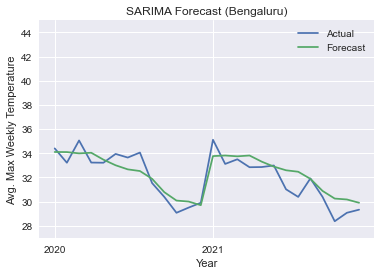

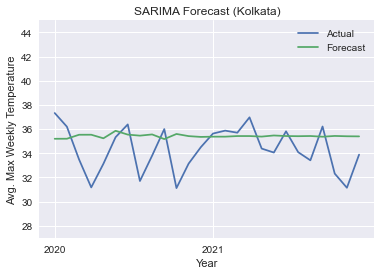

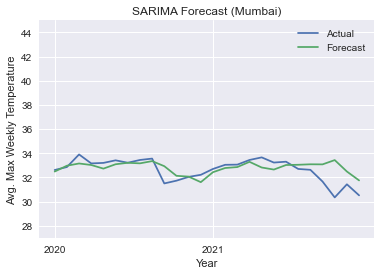

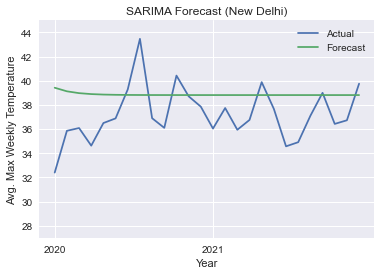

In [625]:
for city in city_list:
    data_c_test = SARIMA_forecast(city=city)

Looking at the SARIMA order for each city, it is noteworthy that the D and Q for Kolkata are both zero and the P is only one. In addition, New Delhi’s P, D and Q are all zero. This suggests the most accurate models for these two cities are ones that have very little to no seasonal order. This is not entirely surprising given that we’ve seen the max temperatures for these cities are highly variable and inconsistent from year to year.

We can see from the plots of the forecasts for Bengaluru and Mumbai do a relatively good job of predicting the seasonal contour of the max temperatures. Conversely, Kolkata and New Delhi show predictions that are almost completely flat from week to week. This is not surprising given that we saw above little to no seasonal SARIMA order for these cities. 

## Conclusion

We see from the MAPE scores from the two models that SARIMA performed slightly better for all four of the cities. The LOESS + ARIMA model tended to overfit to the historical data while the SARIMA model better segregated the seasonal components from the noise. More broadly speaking, both models indicate the difficulty in forecasting the max temperatures for cities like Kolkata and New Delhi with highly variable and inconsistent seasonal patterns.

This model could potentially be improved by use of exogenous variables. There may be trends relating to concentration of certain chemical compounds in the atmosphere, changes in sea level, etc. that could be forecasted for the future then used in a SARIMAX model as exogenous variables used to predict max temperature. 